<a href="https://colab.research.google.com/github/100495699/Aprendizaje/blob/main/Aprendizaje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![LogoUC3M](https://login.uc3m.es/imgs/uc3m.png)


# Practica 1: Predicción de abandonos de empleados

Siqi Xu Sun (g84) - 100495699

Francisco Javier Ruiz Joya (g85) - 100486405






# Introducción

El objetivo de esta práctica es la obtención de un modelo de clasificación para predecir el abandono de los empleados de una empresa utilizando diferentes métodos relacionados con el aprendizaje automático. Para ello, se realizará un pequeño estudio de los datos y se usarán métodos como KNN, Trees, SVM o RNA para desarrollar un modelo capaz de predecir dichos abandonos.

La tasa de abandonos es una información muy importante y útil para que las empresas puedan anticipar de una manera eficaz los empleados que potencialmente puedan abandonar la empresa.

# EDA simplificado

En esta sección vamos a cargar y analizar el dataset para entender mejor su estructura. Identificaremos los diferentes campos, sus valores, valores faltantes, rangos y una matriz de dependencia. Además, obtendremos los campos más importantes para el modelo de predicción de abandonos.

Primero, importaremos algunas librerías necesarias: *Pandas* para leer el dataset, *sklearn* para el desarrollo de los modelos y *numpy* junto con *matplotlib* para funciones adicionales.



In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, recall_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import neighbors
!pip install statsmodels

El primer paso será cargar el dataset con *pandas* y mostrar el numero de filas, columnas y el nombre de todas las columnas

In [43]:
dataset = pd.read_csv('attrition_availabledata_05.csv')
num_filas, num_columnas = dataset.shape

# Estructura del dataset
print(f"Número de filas: {num_filas}")
print(f"Número de columnas: {num_columnas}")
# Ver nombres de todas las columnas
print("Nombres de las columnas:")
print(dataset.columns.tolist())



Número de filas: 2940
Número de columnas: 31
Nombres de las columnas:
['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition']


Podemos observar que tenemos 31 columnas de diferentes tipos de datos, por lo que el siguiente paso es ver los diferentes valores únicos que toman los diferentes registros para cada columna. De esta forma será más fácil ver el tipo de las variables (categóricas, ordinales o numéricas)

In [44]:
for col in dataset.columns:
    valores_unicos = dataset[col].unique()
    print(f"Valores '{col}':{valores_unicos}")

Valores 'hrs':[6.61262494 6.02681504 6.96645582 ... 6.59509148 7.38075747 6.45303882]
Valores 'absences':[18 11 12 10 14 15  2 17 23 22  8  4  5  9  6 21  3  7 19 16 20 13 24  1]
Valores 'JobInvolvement':[4 3 2 1]
Valores 'PerformanceRating':[3 4]
Valores 'EnvironmentSatisfaction':[ 3.  4.  2.  1. nan]
Valores 'JobSatisfaction':[ 3.  4.  1.  2. nan]
Valores 'WorkLifeBalance':[ 2.  3.  1.  4. nan]
Valores 'Age':[31 33 48 42 34 53 50 39 37 45 36 30 40 41 27 43 38 24 18 51 32 47 26 46
 44 29 60 22 35 28 59 57 58 55 20 25 54 19 49 52 56 23 21]
Valores 'BusinessTravel':['Travel_Frequently' 'Travel_Rarely' 'Non-Travel']
Valores 'Department':['Sales' 'Human Resources' 'Research & Development']
Valores 'DistanceFromHome':[10  3  8 11  9  5  6  2  1 28 29 23 19 21 14 25  4  7 16 24 12 26 18 15
 22 17 27 20 13]
Valores 'Education':[3 1 4 2 5]
Valores 'EducationField':['Technical Degree' 'Marketing' 'Medical' 'Life Sciences' 'Other'
 'Human Resources']
Valores 'EmployeeCount':[1]
Valores 'Employe

Una vez tenemos los valores únicos que pueden tomar las variables se observan:

*   **Variables numericas:** hrs, absences, Age, DistanceFromHome, MonthlyIncome, NumCompaniesWorked, PercentSalaryHike, TotalWorkingYears, YearsAtCompany, YearsSinceLastPromotion, YearsWithCurrManager

*   **Variables categóricas:** BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus, Attrition

*   **Variables ordinales:** JobInvolvement, PerformanceRating, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, Education, JobLevel, StockOptionLevel, TrainingTimesLastYear

Además, localizamos una serie de variables que toman valores constantes o son ids y, por tanto, no aportan información adicional y podrian eliminarse.

* **Variables especiales:** EmployeeCount, EmployeeID, Over18, StandardHours



Si ahora nos centramos en las variables numéricas, hay que tener en cuenta las variables con muchos valores faltantes o valores no validos. Para controlar esto, vamos a ver la cantidad de valores no validos o faltantes para las variables de dicha categoría.


In [45]:
columnas_numericas= ["hrs", "absences", "Age", "DistanceFromHome", "MonthlyIncome", "NumCompaniesWorked",
 "PercentSalaryHike", "TotalWorkingYears", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]

print(dataset[columnas_numericas].isnull().sum())

hrs                         0
absences                    0
Age                         0
DistanceFromHome            0
MonthlyIncome               0
NumCompaniesWorked         13
PercentSalaryHike           0
TotalWorkingYears           6
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64


Observamos que en la columna NumCompaniesWorked y TotalWorkingYears hay 13 y 6  registros respectivamente que no tienen valor. Dado que se trata de pocos registros, no supone mucho riesgo, or lo que se dejará como esta por el momento.

Para las cariables categóricas, es importante saber factores como la cardinalidad, los valores faltantes y, si es necesario, la codificacion de variables para transformarlas a numericas.

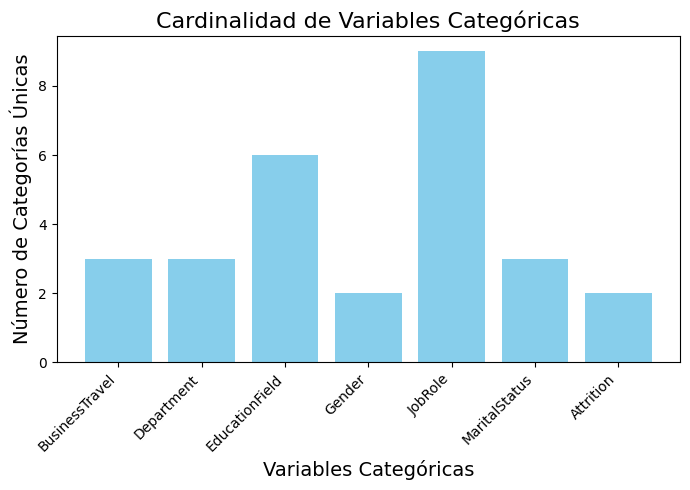

In [51]:
columnas_categoricas = ["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus", "Attrition"]
card = dataset[columnas_categoricas].nunique()

# Crear un gráfico de barras para mostrar la cardinalidad
plt.figure(figsize=(7, 5))
plt.bar(card.index, card.values, color='skyblue')
plt.title("Cardinalidad de Variables Categóricas", fontsize=16)
plt.xlabel("Variables Categóricas", fontsize=14)
plt.ylabel("Número de Categorías Únicas", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor legibilidad

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el layout para que no se corten las etiquetas
plt.show()

Hacemos lo mismo para las variables ordinales


In [52]:
columnas_ordinales = ["JobInvolvement", "PerformanceRating", "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance", "Education", "JobLevel", "StockOptionLevel", "TrainingTimesLastYear"]
print(dataset[columnas_ordinales].isnull().sum())

JobInvolvement             0
PerformanceRating          0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
Education                  0
JobLevel                   0
StockOptionLevel           0
TrainingTimesLastYear      0
dtype: int64


Podemnos observar que hay más registros con datos faltantes. Esto se resolverá en el preprocesado con la estrategia elegida.

Para determinar el tipo de problema que se plantea, se observa la variable objetivo 'attrition'. Esta variable es de tipo categórica, por tanto, podemos establecer el problema como un problema de clasificación.

Para determinar si el dataset está desbalanceado mostramos en una grafica la cantidad de filas con el valor 'No' junto con los registros con el valor 'Si'.

           Cantidad  Porcentaje
Attrition                      
No             2403   83.786611
Yes             465   16.213389


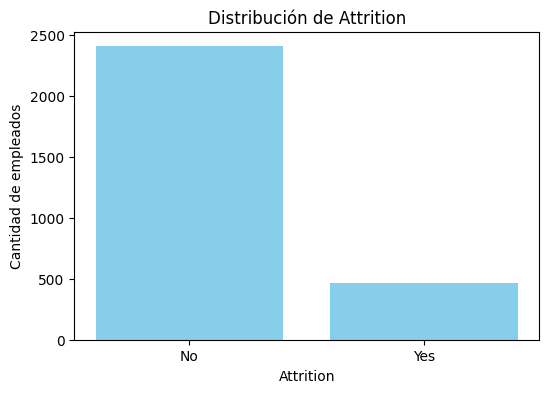

In [53]:
conteo_attrition = dataset["Attrition"].value_counts()
porcentaje_attrition = dataset["Attrition"].value_counts(normalize=True) * 100

print(pd.DataFrame({"Cantidad": conteo_attrition, "Porcentaje": porcentaje_attrition}))

plt.figure(figsize=(6, 4))
plt.bar(conteo_attrition.index, conteo_attrition.values, color='skyblue')
plt.xlabel("Attrition")
plt.ylabel("Cantidad de empleados")
plt.title("Distribución de Attrition")
plt.show()


Se observa que alrededor de un 83% de los registros pertenecen a la clase mayoritaria 'NO', por lo que el dataset está desbalanceado. Hay que tener en cuenta esta información para que, a la hora de dividir el dataset en train-test, haya una distribución similar de registros de cada clase y en la eleccion de las métricas de evaluación.

Por último, se realiza una matriz de correlación para determinar qué variables están relacionadas entre sí para evitar posibles variables altamente relaciondas.

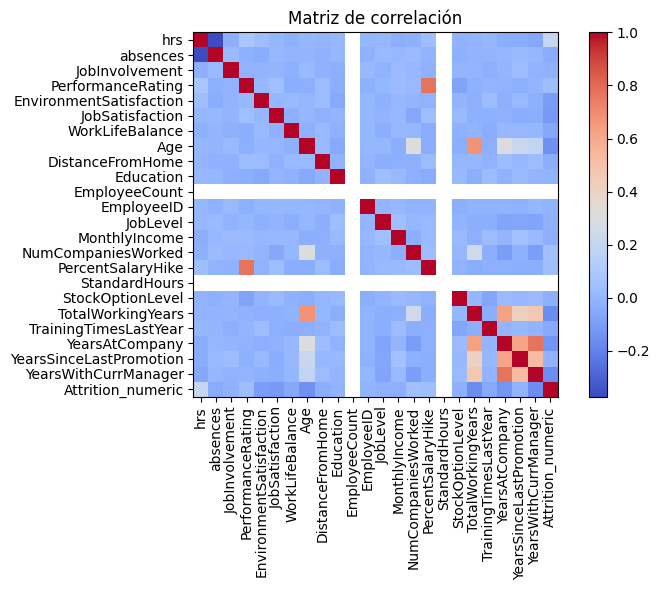

In [54]:
dataset_matrix = dataset.copy()
dataset_matrix["Attrition_numeric"] = dataset["Attrition"].map({"Yes": 1, "No": 0})
correlation_matrix = dataset_matrix.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()



# Evaluación

A continuación se divide el dataset original en train y test con una proporcion train (2/3) y test (1/3) manteniendo la proporcion de casos pertenecientes a la clase 'Si' en la variable objetivo. Además se elimina la columna objetivo en el set de entrenamiento y prueba para evitar sobreajustar los modelos. Para la evaluacion interna, se usara un cross validation de 3 folds en el conjunto de test y luego se calcularán las métricas para el conjunto de test.


In [55]:
from sklearn.preprocessing import LabelEncoder

dataset = dataset.dropna()
columnas_categoricas.remove("Attrition")
X = dataset.drop(columns=["Attrition"])
y = dataset["Attrition"]
y = y.map({"Yes": 1, "No": 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=42, stratify=y)

train_distribution = y_train.value_counts(normalize=True) * 100
test_distribution = y_test.value_counts(normalize=True) * 100

print("\nDistribución en el conjunto de entrenamiento (Train):")
print(train_distribution)
print("\nDistribución en el conjunto de prueba (Test):")
print(test_distribution)



Distribución en el conjunto de entrenamiento (Train):
Attrition
0    83.786611
1    16.213389
Name: proportion, dtype: float64

Distribución en el conjunto de prueba (Test):
Attrition
0    83.786611
1    16.213389
Name: proportion, dtype: float64


Para la evaluacion de los modelos se utilizarán métricas como balanced accuracy, accuracy y TPR / TNR. El criterio de seleccion del mejor modelo se basa en el que mejor puntuacion tenga en las diferentes métricas.
Con respecto al preprocesado de los datos, se usarán diferentes estrategias para el imputado (mean y median) y diferentes metodos de escalado (Standard, MinMax y Robust) para las variables numericas. Para las variables categoricas y ordinales se usará un SimpleImputer con la estrategia de 'most frequent'ademas de One hot encoder y ordinal encoder respectivamente.

# KNN

A continuacion definimos y entrenamos los diferentes modelos que usan el metodo de K-nearest neighbors (KNN).
Para obtener los mejores hiperparámetros y el mejor escaler e imputer, se utiliza ColumnTransformer y pipelines para hacer el preprocesado y GridSearch para hacer la búsqueda de los mejores parametros basando su respuesa final en la precisión del modelo.

Dentro de esta busqueda de la mejor configuración de parámetros se encuentra el modelo por defecto de KNN (n_neighbors = 5, weights= 'uniform', metric= 'minkowski' y algorithm = 'auto').

Los hiperparametros a optimizar son:


*   Numero de vecinos
*   Pesos
*   Algoritmo
*   Métrica





In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, confusion_matrix
import time
# Search space
# rango de valores de hiperparametros que el metodo grid search CV va a probar
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # Imputación para numéricas
        ("scaler", StandardScaler())  # Escalado de datos numéricos
    ]), columnas_numericas),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para categóricas
        ("encoder", OneHotEncoder(handle_unknown="ignore"))  # OneHot para variables categóricas
    ]), columnas_categoricas),

    ("ord", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para ordinales
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # OrdinalEncoder para categorías ordenadas
    ]), columnas_ordinales)
])

param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],
    "classifier__n_neighbors": [3, 5, 7, 11],
    "classifier__weights": ["uniform", "distance"],
    "classifier__algorithm": ["auto", "ball_tree", "kd_tree"],
    "classifier__metric": ["euclidean", "manhattan", "minkowski"]
}

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", neighbors.KNeighborsClassifier())]
)

inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search_cv = GridSearchCV(
    clf, param_grid,
    #n_iter=6,
    cv=inner,
    scoring=["balanced_accuracy", "accuracy"],
    refit="balanced_accuracy"
)


start_time = time.time()
search_cv.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time


print(f"Tiempo de entrenamiento: {training_time:.4f} segundos")
print("Mejores Parametros:")
print(search_cv.best_params_)

Tiempo de entrenamiento: 146.9338 segundos
Mejores Parametros:
{'classifier__algorithm': 'auto', 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance', 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': RobustScaler()}


Como podemos observar, debido a la cantidad de hiperparámetros a optimizar, el coste computacional aumenta considerablemente al estar más de 2 minutos esperando la mejor configuración.

A continuación analizamos el impacto del número de vecinos en los modelos creados.

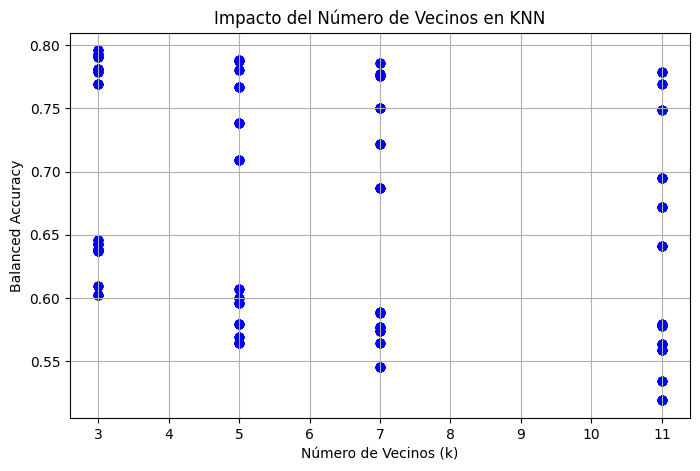

In [57]:
import matplotlib.pyplot as plt

results = pd.DataFrame(search_cv.cv_results_)
neighbors_results = results[["param_classifier__n_neighbors", "mean_test_balanced_accuracy"]]

neighbors_results = neighbors_results.sort_values(by="param_classifier__n_neighbors")

plt.figure(figsize=(8, 5))
plt.scatter(neighbors_results["param_classifier__n_neighbors"], neighbors_results["mean_test_balanced_accuracy"], marker="o", color="b")
plt.xlabel("Número de Vecinos (k)")
plt.ylabel("Balanced Accuracy")
plt.title("Impacto del Número de Vecinos en KNN")
plt.grid()
plt.show()

metric_results = results[["param_classifier__metric", "mean_test_balanced_accuracy"]]


Como se puede obserar, a medida que el numero de vecinos aumenta, la precisión de los modelos de dispersa más, por lo que dependerian de la configuración de los demas parametros.

Ahora calculamos las metricas del mejor modelo

In [60]:

y_pred = search_cv.best_estimator_.predict(X_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


TN, FP, FN, TP = cm.ravel()
TPR = TP / (TP + FN)  # Sensibilidad (recall positivo)
TNR = TN / (TN + FP)  # Especificidad (recall negativo)


print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"TPR (Sensibilidad / Recall Positivo): {TPR:.4f}")
print(f"TNR (Especificidad / Recall Negativo): {TNR:.4f}")

Balanced Accuracy: 0.8748
Accuracy: 0.9341
TPR (Sensibilidad / Recall Positivo): 0.7871
TNR (Especificidad / Recall Negativo): 0.9625


Ahora representamos los resultados en una matriz de confusión para ver la las predicciones realizadas con los valores reales.

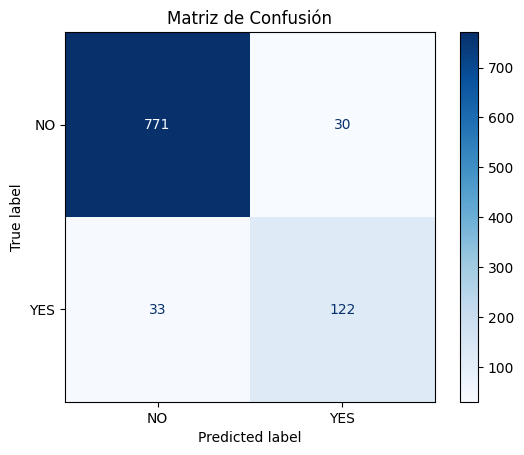

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO', 'YES'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

Podemos observar que en general hace bien las predicciones salvo 63 registros han sido incorrectos.

# TREES

Ahora hacemos lo mismo que se realizó en el apartado de KNN pero esta vez usando arbles de decisión.
Los parametros a optimizar en este caso son:


*   Profundidad máxima
*   Min samples leaf
*   Min samples split



In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import time
# Search space
# rango de valores de hiperparametros que el metodo grid search CV va a probar
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # Imputación para numéricas
        ("scaler", StandardScaler())  # Escalado de datos numéricos
    ]), columnas_numericas),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para categóricas
        ("encoder", OneHotEncoder(handle_unknown="ignore"))  # OneHot para variables categóricas
    ]), columnas_categoricas),

    ("ord", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para ordinales
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # OrdinalEncoder para categorías ordenadas
    ]), columnas_ordinales)
])

param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],
    "classifier__max_depth": [2, 4, 6, 8, 10, 12, 14, None],
    #"classifier__criterion": ["gini", "entropy", "log_loss"],
    #"classifier__splitter": ["best", "random"],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],

}

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)

inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search_cv = GridSearchCV(
    clf, param_grid,
    cv=inner,
    scoring="balanced_accuracy"
)

start_time = time.time()
search_cv.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.4f} segundos")
print("Mejores Parametros:")
print(search_cv.best_params_)

Tiempo de entrenamiento: 70.5854 segundos
Mejores Parametros:
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': RobustScaler()}


Ahora analizamos el efecto de max_depth en las métricas

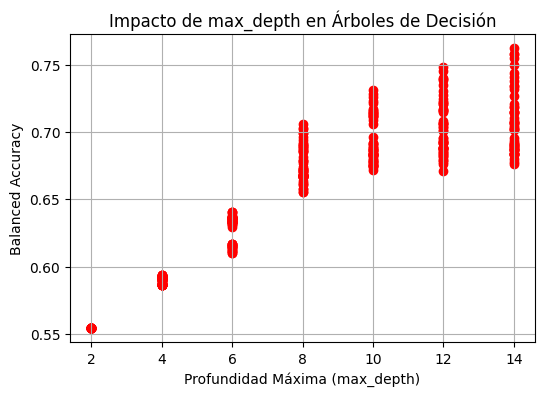

In [63]:
import matplotlib.pyplot as plt

results = pd.DataFrame(search_cv.cv_results_)
depth_results = results[["param_classifier__max_depth", "mean_test_score"]]

depth_results = depth_results.sort_values(by="param_classifier__max_depth")

plt.figure(figsize=(6, 4))
plt.scatter(depth_results["param_classifier__max_depth"], depth_results["mean_test_score"], marker="o", color="r")
plt.xlabel("Profundidad Máxima (max_depth)")
plt.ylabel("Balanced Accuracy")
plt.title("Impacto de max_depth en Árboles de Decisión")
plt.grid()
plt.show()


Podemos observar que con una profundidad baja, las predicciones son basicamente un lanzamiento de una moneda. Sin embargo, a medida que la profundidad aumenta, la precisión lo hace también con un coste computacional elevado.

Calculamos las metricas del mejor modelo

In [64]:
y_pred = search_cv.best_estimator_.predict(X_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

TN, FP, FN, TP = cm.ravel()
TPR = TP / (TP + FN)  # Sensibilidad (recall positivo)
TNR = TN / (TN + FP)  # Especificidad (recall negativo)


print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"TPR (Sensibilidad / Recall Positivo): {TPR:.4f}")
print(f"TNR (Especificidad / Recall Negativo): {TNR:.4f}")

Balanced Accuracy: 0.8366
Accuracy: 0.9006
TPR (Sensibilidad / Recall Positivo): 0.7871
TNR (Especificidad / Recall Negativo): 0.9625


Ahora representamos los resultados en una matriz de confusión para ver la las predicciones realizadas con los valores reales.

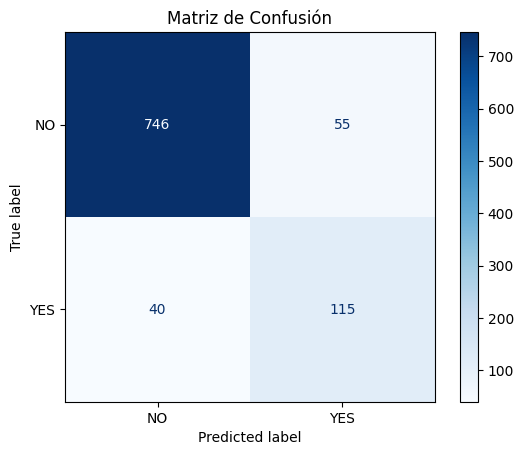

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO', 'YES'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

Con este modelo basado en arboles de decision tenemos unos resultados similares pero ligeramente peores, con 95 registros cuyas predicciones son erroneas.

# Modelos Lineales y SVM

Modelo lineal

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

import time
# Search space
# rango de valores de hiperparametros que el metodo grid search CV va a probar
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # Imputación para numéricas
        ("scaler", StandardScaler())  # Escalado de datos numéricos
    ]), columnas_numericas),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para categóricas
        ("encoder", OneHotEncoder(handle_unknown="ignore"))  # OneHot para variables categóricas
    ]), columnas_categoricas),

    ("ord", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para ordinales
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # OrdinalEncoder para categorías ordenadas
    ]), columnas_ordinales)
])

param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],

}


clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search_cv = GridSearchCV(
    clf, param_grid,
    cv=inner,
    scoring="balanced_accuracy"
)

start_time = time.time()
search_cv.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.4f} segundos")
print("Mejores Parametros:")
print(search_cv.best_params_)

Tiempo de entrenamiento: 1.3938 segundos
Mejores Parametros:
{'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': StandardScaler()}


Calculamos las metricas

In [26]:
y_pred = search_cv.best_estimator_.predict(X_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

TN, FP, FN, TP = cm.ravel()
TPR = TP / (TP + FN)  # Sensibilidad (recall positivo)
TNR = TN / (TN + FP)  # Especificidad (recall negativo)


print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"TPR (Sensibilidad / Recall Positivo): {TPR:.4f}")
print(f"TNR (Especificidad / Recall Negativo): {TNR:.4f}")

Balanced Accuracy: 0.6244
Accuracy: 0.8588
TPR (Sensibilidad / Recall Positivo): 0.2774
TNR (Especificidad / Recall Negativo): 0.9713


Podemos observar que este modelo es considerablemente peor que los dos anteriores.

SVM lineal


In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

import time
# Search space
# rango de valores de hiperparametros que el metodo grid search CV va a probar
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # Imputación para numéricas
        ("scaler", StandardScaler())  # Escalado de datos numéricos
    ]), columnas_numericas),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para categóricas
        ("encoder", OneHotEncoder(handle_unknown="ignore"))  # OneHot para variables categóricas
    ]), columnas_categoricas),

    ("ord", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para ordinales
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # OrdinalEncoder para categorías ordenadas
    ]), columnas_ordinales)
])

param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__class_weight": [None, "balanced"]
}


clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LinearSVC(dual=False, max_iter=1000))]
)

inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search_cv = GridSearchCV(
    clf, param_grid,
    cv=inner,
    scoring="balanced_accuracy"
)

start_time = time.time()
search_cv.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.4f} segundos")
print("Mejores Parametros:")
print(search_cv.best_params_)

Tiempo de entrenamiento: 17.3941 segundos
Mejores Parametros:
{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': StandardScaler()}


In [29]:
y_pred = search_cv.best_estimator_.predict(X_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

TN, FP, FN, TP = cm.ravel()
TPR = TP / (TP + FN)  # Sensibilidad (recall positivo)
TNR = TN / (TN + FP)  # Especificidad (recall negativo)


print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"TPR (Sensibilidad / Recall Positivo): {TPR:.4f}")
print(f"TNR (Especificidad / Recall Negativo): {TNR:.4f}")

Balanced Accuracy: 0.7303
Accuracy: 0.7312
TPR (Sensibilidad / Recall Positivo): 0.7290
TNR (Especificidad / Recall Negativo): 0.7316


Este modelo es ligeramente mejor que el que usa logistic regression pero peor que los que usan arboles de decision o KNN. Sin embargo, vamos a ver su matriz de confusion para revisar las predicciones realizadas.

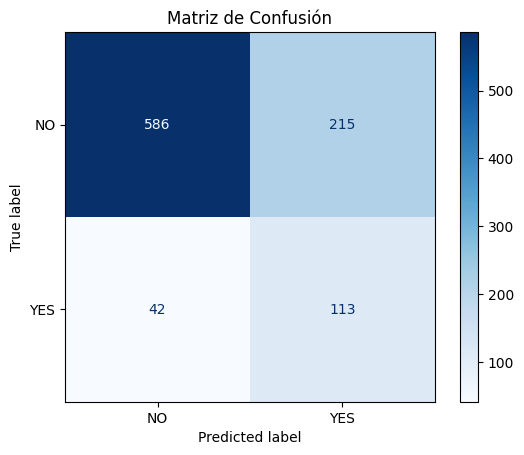

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO', 'YES'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

Podemos observar que tiene un gran problema con los registros de usuarios que no abandonan la empresa, ya que una gran cantidad de registros pertenecientes a dicha clase estan siendo etiquetados en la clase contraria.

# RNA

Como modelo extra, hemos decidido probar redes neuronales y asi comparar resultados con respecto a los demas modelos. Al igual que para los modelos anteriores, se ha realizado un ajuste de hiperparámetros para obtener la mejor configuración

Los parametros optimizados son:


*   Numero de neuronas
*   Tamaño de capas ocultas
*   alpha



In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import time
# Search space
# rango de valores de hiperparametros que el metodo grid search CV va a probar
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # Imputación para numéricas
        ("scaler", StandardScaler())  # Escalado de datos numéricos
    ]), columnas_numericas),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para categóricas
        ("encoder", OneHotEncoder(handle_unknown="ignore"))  # OneHot para variables categóricas
    ]), columnas_categoricas),

    ("ord", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para ordinales
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # OrdinalEncoder para categorías ordenadas
    ]), columnas_ordinales)
])

param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],
    "classifier__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 100)],
    #"classifier__learning_rate_init": [0.001, 0.01, 0.1],
    "classifier__alpha": [0.0001, 0.001, 0.01]
}

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", MLPClassifier(early_stopping=True, learning_rate_init=0.001, max_iter=500, solver='adam'))]
)

inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search_cv = GridSearchCV(
    clf, param_grid,
    cv=inner,
    scoring="balanced_accuracy"
)

start_time = time.time()
search_cv.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.4f} segundos")
print("Best params:")
print(search_cv.best_params_)
print("Estimacion de rendimiento futuro:")
print(search_cv.best_score_)

Tiempo de entrenamiento: 73.2239 segundos
Best params:
{'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100, 100), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__num__scaler': RobustScaler()}
Estimacion de rendimiento futuro:
0.6945096518634754


Calculamos las metricas del mejor modelo

In [41]:
y_pred = search_cv.best_estimator_.predict(X_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = cm.ravel()
TPR = TP / (TP + FN)  # Sensibilidad (recall positivo)
TNR = TN / (TN + FP)  # Especificidad (recall negativo)


print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"TPR (Sensibilidad / Recall Positivo): {TPR:.4f}")
print(f"TNR (Especificidad / Recall Negativo): {TNR:.4f}")

Balanced Accuracy: 0.8747
Accuracy: 0.9383
TPR (Sensibilidad / Recall Positivo): 0.7806
TNR (Especificidad / Recall Negativo): 0.9688


Para este modelo se obtiene un rango de balanced accuracy diferente cada vez que se ejecuta, variando entre 0.80-0.87, que es el máximo de precision obtenido en los modelos estudiados, lo que lo hace el mejor modelo. Para ver sus predicciones las mostramos en una matriz de confusion.

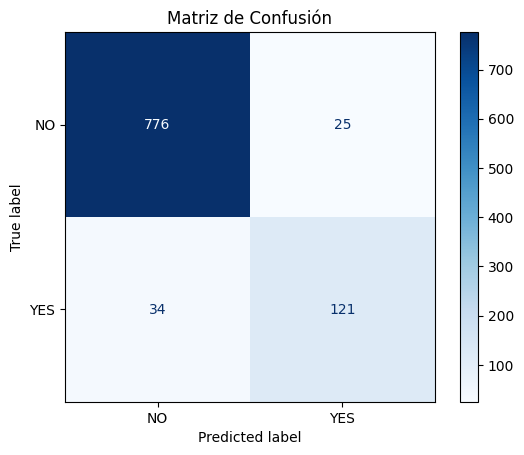

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO', 'YES'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

Observamos un rendimiento similar a KNN pero con una cantidad de 59 registros mal etiquetados.

# Resultados

mejor es  RNA > KNN > trees >> SVM > Lineal
Para elegir el mejor modelo hemos visto el que mejor balanced accuracy tiene y el que menos registros etiquete mal. Siguiendo estos criterios, el orden seria:


1.   Redes de Neuronas (RNA)
2.   K-Nearest Neighbors (KNN)
3.   Decision Trees
4.   Máquinas de vector soporte (SVM)
5.   Modelo Lineal (Logistic Regression)


Por tanto haremos las predicciones para el dataset de competicion con el modelo resultante del entrenamiento con RNA.



In [ ]:
import joblib
best_model = search_cv.best_estimator_
joblib.dump(best_model, "best_model.pkl")

print ("Modelos guardado como best_model.pkl")